Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [1]:
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns

from util.map import Map
from util.generate_points import list_to_dict, gen_square, gen_disc

wandb.login()

wandb: Currently logged in as: hydrofin (hydrofin-personal). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="embedding-eval-framework", entity="hydrofin")
wandb.run

wandb: Currently logged in as: hydrofin. Use `wandb login --relogin` to force relogin


In [3]:
args = Map(
    batch_size = 64,
    epochs = 50,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    rg_radius = 0.05,
    layers = 10,
    layer_size = 16,
    train_size = 0.7
)

In [4]:
rg_radius = args.rg_radius if args.rg_radius > 0 else math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = list_to_dict(gen_disc(args.graph_size))
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

Nodes: 1000
Edges: 4765
Average Degree: 9.53
Largest Component Size: 1000


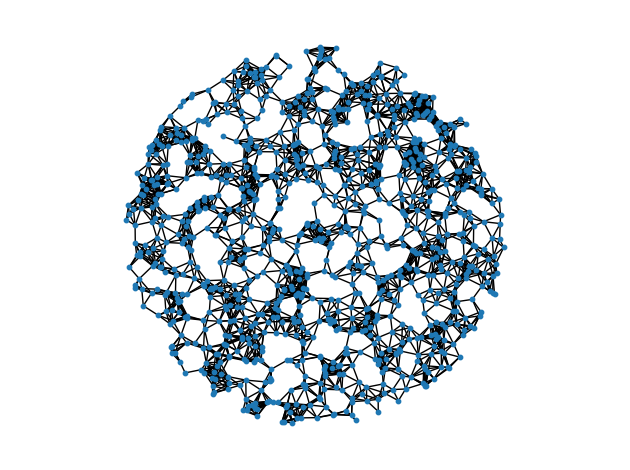

<Figure size 640x480 with 0 Axes>

In [5]:
print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')

fig = plt.figure()
ax = fig.add_subplot()

nx.draw_networkx(nx_graph, pos, ax=ax, node_size=10, with_labels=False, labels={})
plt.axis('off')
fig.set_facecolor('w')

plt.axis('equal')
fig.tight_layout()
plt.show()

wandb.log({
    "generated_graph": wandb.Image(plt)
})

In [6]:
#graph_nodes_pos = [ node['pos'] for node in  ]

graph_nodes = nx.nodes(nx_graph)

# all combinations of x and y (with x > y)
print("generating edge pairs...", end='')
ds_edge_pairs = [ [ei0, ei1] for ei0 in range(nx_graph.number_of_nodes()) for ei1 in range(ei0 + 1, nx_graph.number_of_nodes()) ]
print(f"DONE generated {len(ds_edge_pairs)} pairs")
ds_edges_pos = [ [graph_nodes[ei0]['pos'][0], graph_nodes[ei0]['pos'][1], graph_nodes[ei1]['pos'][0], graph_nodes[ei1]['pos'][1]] for [ei0, ei1] in tqdm(ds_edge_pairs, desc="mapping edge positions") ]
ds_edges_label = [ 1 if nx_graph.has_edge(ei0, ei1) else 0 for [ei0, ei1] in tqdm(ds_edge_pairs, desc="creating labels for edges") ]

def z2polar(z: (float, float)) -> [float, float]:
    rho = np.sqrt(z[0]**2 + z[1]**2)
    phi = np.arctan2(z[1], z[0])
    return [rho, phi]

def zs2polars(zs: [(float, float)]) -> [float, float]:
    return np.array([ z2polar(z) for z in zs ]).flatten()

generating edge pairs...DONE generated 499500 pairs


creating labels for edges: 100%|██████████| 499500/499500 [00:00<00:00, 2484367.69it/s]


In [7]:
# tensorflow

# generate dataset from graph from previous
full_dataset = tf.data.Dataset.from_tensor_slices((ds_edges_pos, ds_edges_label)).batch(args.batch_size)

# split dataset
full_dataset = full_dataset.shuffle(nx_graph.number_of_nodes())
train_dataset = full_dataset.take(int(args.train_size * nx_graph.number_of_nodes()))
test_dataset = full_dataset.take(int((1 - args.train_size) * nx_graph.number_of_nodes()))

# build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(thresholds=0),
        tf.keras.metrics.AUC(
            curve="PR"
        ),
        #tfma.metrics.AUCPrecisionRecall()
    ]
)

# train
train_history = dense_model.fit(train_dataset, epochs=args.epochs, callbacks=[WandbCallback()])

# evaluate
test_loss, test_acc, e1, e2 = dense_model.evaluate(test_dataset, verbose=0)
dense_model.summary()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
700/700 [==============================] - 2s 1ms/step - loss: 0.0821 - accuracy: 0.9904 - recall: 1.0000 - auc: 0.0228
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0196 - accuracy: 0.9915 - recall: 1.0000 - auc: 0.4308
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0137 - accuracy: 0.9939 - recall: 1.0000 - auc: 0.6335
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0119 - accuracy: 0.9949 - recall: 1.0000 - auc: 0.7801
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0122 - accuracy: 0.9950 - recall: 1.0000 - auc: 0.7453
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0106 - accuracy: 0.9955 - recall: 1.0000 - auc: 0.8247
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.9961 - recall: 1.0000 - auc: 0.8317
Epoch 8/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0112 - 

In [8]:
predictions = dense_model.predict(ds_edges_pos) # cartesian

15610/15610 [==============================] - 10s 608us/step


In [9]:
predictions

array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [1.5047766e-25],
       [8.0770309e-36],
       [4.8687100e-29]], dtype=float32)

In [10]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)
edges = [ pair for pair, prediction in zip(ds_edge_pairs, predictions) if (prediction[0] >= 0.1) ] # and (pair[0] != pair[1])
pred_graph.add_edges_from(edges)

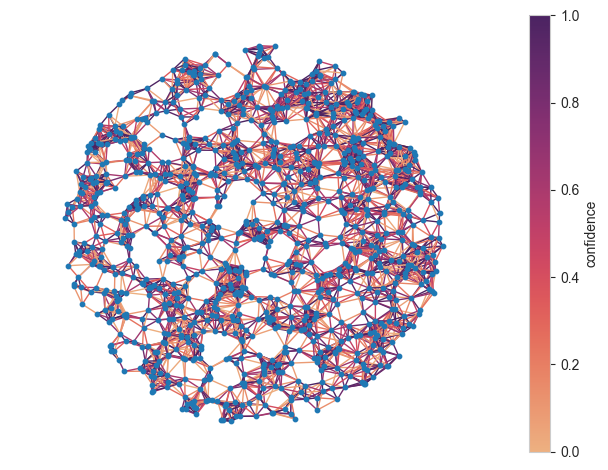

In [11]:
c1='#1f77b4' #blue
c2='green' #green

colors = np.array([ prediction[0] for prediction in predictions if (prediction[0] >= 0.1)])
colormap = sns.color_palette("flare", as_cmap=True)
options = {
    #"node_color": "#A0CBE2",
    "edge_color": colors,
    "node_size": 10,
    "edge_cmap": colormap,
    "with_labels": False,
}

fig = plt.figure()
ax = fig.add_subplot()
fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), ax=ax, label="confidence")

nx.draw_networkx(pred_graph, pos, ax=ax, **options, label="reconstructed graph")

# Setting it to how it was looking before.
plt.axis('off')
plt.axis('equal')
fig.set_facecolor('w')

#plt.legend()

fig.tight_layout()
plt.show()

In [12]:
wandb.log({
    "predicted_graph": wandb.Image(plt)
})

<Figure size 640x480 with 0 Axes>

In [13]:
wandb.finish()

accuracy,▁▂▄▅▆▇▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇███
auc,▁▄▆▇▇▇▇▇▇▇██▇█▇▇▇▇▇████▇██████▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.99705
auc,0.92858
epoch,49
loss,0.00647
recall,1.0
